
# Convolutional Neural Networks (CNNs) with PyTorch


Original file is located at
    https://drive.google.com/file/d/1LESKvWyGptijIYwyOi0U3CZ1G3QvvYFy/view?usp=sharing



## 1. CNNs, Visualization, Parameter Calculation, and Transfer Learning with PyTorch

**Goal:** This notebook extends the previous version by adding network architecture visualization and parameter calculation.

**Dataset:** FashionMNIST.

**Outline:**
1.  **Convolution Operation:** Understanding the core convolution operation.
2.  **FashionMNIST Dataset:** Loading and visualizing the dataset.
3.  **MLP Classifier:** Building, training, and **visualizing** a simple MLP.
4.  **CNN Classifier:** Building, training, and **visualizing** a CNN.
5.  **Parameter Calculation:** Detailed explanation and code for calculating the number of parameters.
6.  **Transfer Learning with VGG16:** Using a pre-trained VGG16 model on ImageNet, freezing layers, fine-tuning, and evaluating performance.

**Learning Objectives:**
*   Understand the convolution operation and its parameters.
*   Learn how to build CNN architectures using PyTorch.
*   Compare the performance of MLPs and CNNs on image classification.
*   **Visualize network architectures using `torchsummary`.**
*   **Understand and calculate the number of parameters in neural networks.**
*   Apply transfer learning using a pre-trained model.

## 2. The Convolution Operation

The convolution operation is the fundamental building block of CNNs. It involves sliding a small filter (or kernel) over an input image, performing element-wise multiplication, and summing the results to produce a single output value. This process is repeated for every possible position of the filter on the input image.

**Key Parameters:**
*   **Filter (Kernel):** A small matrix of weights that is convolved with the input image.
*   **Stride:** The number of pixels by which the filter is shifted at each step.
*   **Padding:** Adding extra pixels around the border of the input image to control the size of the output feature map.
*   **Input Channels:** The number of channels in the input image (e.g., 1 for grayscale, 3 for RGB).
*   **Output Channels:** The number of different filters used in the convolution layer.

**Example:**

Let's create a simple example to illustrate the convolution operation in Python using NumPy.

In [ ]:
import numpy as np

In [ ]:
def convolution(image, kernel, stride=1, padding=0):
    """
    Performs a 2D convolution operation.

    Args:
        image: Input image (NumPy array).
        kernel: Convolution filter (NumPy array).
        stride: Stride value.
        padding: Padding value.

    Returns:
        Output feature map (NumPy array).
    """
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Add padding
    padded_image = np.pad(image, pad_width=padding, mode='constant')
    padded_height, padded_width = padded_image.shape

    # Calculate the output dimensions
    output_height = (padded_height - kernel_height) // stride + 1
    output_width = (padded_width - kernel_width) // stride + 1

    # Create the output feature map
    output = np.zeros((output_height, output_width))

    # Perform the convolution
    for i in range(output_height):
        for j in range(output_width):
            start_row = i * stride
            start_col = j * stride
            end_row = start_row + kernel_height
            end_col = start_col + kernel_width
            output[i, j] = np.sum(padded_image[start_row:end_row, start_col:end_col] * kernel)

    return output

In [ ]:
# Example Usage
input_image = np.array([[1, 2, 3],
                        [4, 5, 6],
                        [7, 8, 9]])

In [ ]:
convolution_filter = np.array([[1, 0, -1],
                                [1, 0, -1],
                                [1, 0, -1]]) # Vertical Edge Detection filter

In [ ]:
output_feature_map = convolution(input_image, convolution_filter, stride=1, padding=0)

In [ ]:
print("Input Image:\n", input_image)
print("\nConvolution Filter:\n", convolution_filter)
print("\nOutput Feature Map:\n", output_feature_map)

Input Image:
 [[1 2 3]
 [4 5 6]
 [7 8 9]]

Convolution Filter:
 [[ 1  0 -1]
 [ 1  0 -1]
 [ 1  0 -1]]

Output Feature Map:
 [[-6.]]



## 3. Loading and Visualizing the FashionMNIST Dataset

Now, let's load the FashionMNIST dataset using PyTorch.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
# Define the data transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

In [ ]:
# Load the training and testing datasets
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 176kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.26MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.0MB/s]


In [ ]:
# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
# Define the class names
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [ ]:
# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Convert from CxHxW to HxWxC
    plt.show()

In [ ]:
# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

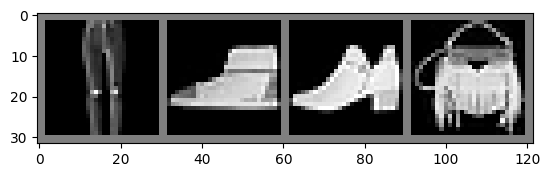

Trouser Ankle boot Ankle boot Bag  


In [ ]:
# Show images
imshow(torchvision.utils.make_grid(images[:4]))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


## 4. Building and Visualizing a Multilayer Perceptron (MLP) Classifier

Let's build a simple Multilayer Perceptron (MLP) and visualize its architecture.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
try:
  from torchsummary import summary  # Import torchsummary
except:
  !pip install torchsummary
  from torchsummary import summary

In [ ]:
# Define the MLP architecture
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input: 28x28 flattened image
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # Output: 10 classes

    def forward(self, x):
        x = torch.flatten(x, 1) # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No softmax here, CrossEntropyLoss handles it
        return x

In [ ]:
# Instantiate the MLP
mlp_net = MLP()

In [ ]:
# Print model summary (Visualizing the architecture)


input_size = (1, 28, 28)  # Channel, Height, Width

# Get the device of the model's parameters
device = next(mlp_net.parameters()).device

# Pass the device as a string ('cuda' or 'cpu')
summary(mlp_net, input_size=input_size, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                   [-1, 64]           8,256
            Linear-3                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


In [ ]:
# Define the loss function and optimizer (Training code remains the same)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_net.parameters(), lr=0.001)

## 🔍 Understanding Cross-Entropy Loss and Softmax

### 🧠 What is Softmax?

The **Softmax function** is often used in classification models to convert raw output scores (logits) from a neural network into probabilities.

For a vector of scores \( z = [z_1, z_2, ..., z_n] \), the Softmax output for class \( i \) is:

$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
$$

This ensures:
- All outputs are between 0 and 1
- All outputs sum to 1 (valid probability distribution)

---

### 💥 What is Cross-Entropy Loss?

**Cross-Entropy Loss** measures the difference between two probability distributions:
- The true distribution (ground truth)
- The predicted distribution (from Softmax)

For a single example with true class \( y \) and predicted probabilities \( p \), the cross-entropy is:

$$
\mathcal{L} = -\log(p_y)
$$

In general:

$$
\mathcal{L} = -\sum_{i=1}^{n} y_i \log(p_i)
$$

Where:
- \( y_i \in \{0, 1\} \) (one-hot encoded true labels)
- \( p_i \) is the predicted probability for class \( i \)

---

### ❓ Are Softmax and Cross-Entropy the Same?

**No**, but they are often **used together**:
- **Softmax** converts logits to probabilities
- **Cross-Entropy** calculates the loss based on those probabilities

🧠 Most deep learning libraries (like PyTorch and TensorFlow) provide **`CrossEntropyLoss`** which:
- Combines **Softmax + Cross-Entropy** into one efficient operation
- Uses **log-softmax internally** for numerical stability

---

### ✅ Summary

| Concept        | Purpose                                              |
|----------------|------------------------------------------------------|
| Softmax        | Converts raw scores to probabilities                 |
| Cross-Entropy  | Measures how well predicted probabilities match labels |

So while **they work hand-in-hand**, **Softmax is not the same as Cross-Entropy Loss**, but they’re often **used together** to train classification models.


In [ ]:
# Training Loop (Unchanged)
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad() # Zero the parameter gradients

        outputs = mlp_net(inputs)  # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step() # Optimize

        running_loss += loss.item()

        if i % 200 == 199: # Print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

[1,   200] loss: 0.726
[1,   400] loss: 0.502
[1,   600] loss: 0.458
[1,   800] loss: 0.434
[2,   200] loss: 0.395
[2,   400] loss: 0.384
[2,   600] loss: 0.371
[2,   800] loss: 0.378
[3,   200] loss: 0.342
[3,   400] loss: 0.341
[3,   600] loss: 0.349
[3,   800] loss: 0.334
[4,   200] loss: 0.316
[4,   400] loss: 0.324
[4,   600] loss: 0.313
[4,   800] loss: 0.316
[5,   200] loss: 0.297
[5,   400] loss: 0.298
[5,   600] loss: 0.301
[5,   800] loss: 0.297


In [ ]:
print('Finished Training the MLP')

Finished Training the MLP


In [ ]:
# Evaluate the MLP on the test set (Unchanged)
correct = 0
total = 0
with torch.no_grad(): # Disable gradient calculation
    for data in testloader:
        images, labels = data
        outputs = mlp_net(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [ ]:
print(f'Accuracy of the MLP on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the MLP on the 10000 test images: 87.00%



## 5. Building and Visualizing a Convolutional Neural Network (CNN) Classifier

Let's build a CNN and visualize its architecture.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
try:
  from torchsummary import summary  # Import torchsummary
except:
  !pip install torchsummary
  from torchsummary import summary

In [ ]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # 1 input channel (grayscale), 32 output channels
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Input: 64 channels, 7x7 image size after pooling
        self.fc2 = nn.Linear(128, 10) # Output: 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No softmax here, CrossEntropyLoss handles it
        return x

In [ ]:
# Instantiate the CNN
cnn_net = CNN()

In [ ]:
# Print model summary (Visualizing the architecture)
input_size = (1, 28, 28)  # Channel, Height, Width
summary(cnn_net, input_size=input_size, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
            Linear-6                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 1.61
Estimated Total Size (MB): 1.97
----------------------------------------------------------------


In [ ]:
# Define the loss function and optimizer (Training code remains the same)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_net.parameters(), lr=0.001)

In [ ]:
# Training Loop (Unchanged)
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad() # Zero the parameter gradients

        outputs = cnn_net(inputs)  # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step() # Optimize

        running_loss += loss.item()

        if i % 200 == 199: # Print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

[1,   200] loss: 0.709
[1,   400] loss: 0.428
[1,   600] loss: 0.392
[1,   800] loss: 0.344
[2,   200] loss: 0.303
[2,   400] loss: 0.279
[2,   600] loss: 0.287
[2,   800] loss: 0.274
[3,   200] loss: 0.238
[3,   400] loss: 0.251
[3,   600] loss: 0.235
[3,   800] loss: 0.233
[4,   200] loss: 0.211
[4,   400] loss: 0.211
[4,   600] loss: 0.203
[4,   800] loss: 0.197
[5,   200] loss: 0.184
[5,   400] loss: 0.181
[5,   600] loss: 0.182
[5,   800] loss: 0.185


In [ ]:
print('Finished Training the CNN')

Finished Training the CNN


In [ ]:
# Evaluate the CNN on the test set (Unchanged)
correct = 0
total = 0
with torch.no_grad(): # Disable gradient calculation
    for data in testloader:
        images, labels = data
        outputs = cnn_net(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [ ]:
print(f'Accuracy of the CNN on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the CNN on the 10000 test images: 91.68%



## 6. Parameter Calculation and Explanation

Let's break down how to calculate the number of parameters in each layer of our models.

**A. Linear (Fully Connected) Layer:**

*   Formula: `(Input Features x Output Features) + Bias`

**Example (MLP Layer 1: `self.fc1 = nn.Linear(28 * 28, 128)`):**
*   Input Features: 28 * 28 = 784
*   Output Features: 128
*   Parameters: (784 x 128) + 128 = 100480 + 128 = 100608 parameters

**B. Convolutional Layer:**

*   Formula: `(Kernel Height x Kernel Width x Input Channels x Output Channels) + Bias`

### **Example: `self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)`**

- **Kernel Size**: 3 × 3  
- **Input Channels**: 1 (grayscale image)  
- **Output Channels**: 32  
- **Parameters**: (3 × 3 × 1 × 32) + 32 = 288 + 32 = **320**

---

### **Example: `self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)`**

- **Kernel Size**: 3 × 3  
- **Input Channels**: 32  
- **Output Channels**: 64  
- **Parameters**: (3 × 3 × 32 × 64) + 64 = 18432 + 64 = **18,496**

---

### **After Flattening: `self.fc1 = nn.Linear(64*7*7, 128)`**

- **Input Features**: 64 × 7 × 7 = 3136  
- **Output Features**: 128  
- **Parameters**: (3136 × 128) + 128 = 401408 + 128 = **401,536**

---

### **Final Layer: `self.fc2 = nn.Linear(128, 10)`**

- **Input Features**: 128  
- **Output Features**: 10  
- **Parameters**: (128 × 10) + 10 = 1280 + 10 = **1,290**

**Important Notes:**
*   Bias: Almost all layers have a bias term. The bias has one parameter for each output feature (or output channel in a convolutional layer).
*   `torchsummary`: We use the `torchsummary` library to automatically calculate and display the number of parameters in each layer and the total number of parameters in the model.
*   Understanding: Knowing how to calculate the number of parameters is important for understanding the complexity of your model and for debugging.

**Code Example: Manual Parameter Calculation**

In [ ]:
def count_parameters(model):
    """
    Counts the total number of trainable parameters in a PyTorch model.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

In [ ]:
mlp_num_params = count_parameters(mlp_net)
cnn_num_params = count_parameters(cnn_net)

In [ ]:
print(f"Total number of trainable parameters in MLP: {mlp_num_params}")
print(f"Total number of trainable parameters in CNN: {cnn_num_params}")

Total number of trainable parameters in MLP: 109386
Total number of trainable parameters in CNN: 421642


## 7. Transfer Learning with VGG16

Now, let's apply transfer learning using a pre-trained VGG16 model.

In [ ]:
import torchvision.models as models

In [ ]:
# Load the VGG16 model pre-trained on ImageNet
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 67.4MB/s]


In [ ]:
# Freeze all the layers of the VGG16 model
for param in vgg16.parameters():
    param.requires_grad = False # Prevents the weights from being updated during training

In [ ]:
# Modify the classifier (fully connected layers) for our task
# FashionMNIST has 10 classes, ImageNet has 1000
num_features = vgg16.classifier[6].in_features # Number of input features to the last layer
vgg16.classifier[6] = nn.Linear(num_features, 10) # Replace the last layer

In [ ]:
# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device) # Move the whole model
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
# Print model summary (Visualizing the architecture)
input_size = (3, 224, 224)  # Channel, Height, Width #Changed input size to (3, 224, 224)
summary(vgg16, input_size=input_size, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Define the loss function and optimizer (only train the classifier)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

In [ ]:
# Data transformation - VGG16 expects images of size 224x224
transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat grayscale 3 times to create 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

In [ ]:
# Load FashionMNIST datasets with the new transformation
trainset_vgg = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_vgg)
testset_vgg = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_vgg)

In [ ]:
trainloader_vgg = torch.utils.data.DataLoader(trainset_vgg, batch_size=64, shuffle=True)
testloader_vgg = torch.utils.data.DataLoader(testset_vgg, batch_size=64, shuffle=False)

In [ ]:
# Training Loop - Train *only* the classifier
num_epochs = 10 # Train for fewer epochs because most layers are frozen

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader_vgg, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to the device

        optimizer.zero_grad() # Zero the parameter gradients

        outputs = vgg16(inputs)  # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step() # Optimize

        running_loss += loss.item()

        if i % 200 == 199: # Print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

[1,   200] loss: 0.702
[1,   400] loss: 0.555
[1,   600] loss: 0.533
[1,   800] loss: 0.542
[2,   200] loss: 0.530
[2,   400] loss: 0.519
[2,   600] loss: 0.525
[2,   800] loss: 0.523
[3,   200] loss: 0.512
[3,   400] loss: 0.527
[3,   600] loss: 0.517
[3,   800] loss: 0.515
[4,   200] loss: 0.517
[4,   400] loss: 0.507
[4,   600] loss: 0.522
[4,   800] loss: 0.525
[5,   200] loss: 0.527
[5,   400] loss: 0.520
[5,   600] loss: 0.518
[5,   800] loss: 0.524
[6,   200] loss: 0.517
[6,   400] loss: 0.521
[6,   600] loss: 0.502
[6,   800] loss: 0.538
[7,   200] loss: 0.518
[7,   400] loss: 0.530
[7,   600] loss: 0.500
[7,   800] loss: 0.519
[8,   200] loss: 0.513
[8,   400] loss: 0.509
[8,   600] loss: 0.526
[8,   800] loss: 0.512
[9,   200] loss: 0.502
[9,   400] loss: 0.513
[9,   600] loss: 0.513
[9,   800] loss: 0.518
[10,   200] loss: 0.507
[10,   400] loss: 0.521
[10,   600] loss: 0.508
[10,   800] loss: 0.530


In [ ]:
print('Finished Training the VGG16 Classifier')

Finished Training the VGG16 Classifier


In [ ]:
# Evaluate the VGG16 model on the test set
correct = 0
total = 0
with torch.no_grad(): # Disable gradient calculation
    for data in testloader_vgg:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [ ]:
print(f'Accuracy of the VGG16 on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the VGG16 on the 10000 test images: 80.44%



## 8. Fine-tuning the VGG16 model
Let's try to fine tune the VGG16 to see if it improves the performance.

In [ ]:
# Unfreeze some of the last convolutional layers
for param in vgg16.features[24:].parameters():  # Unfreeze last 2 conv layers
    param.requires_grad = True

In [ ]:
# Define the loss function and optimizer (train classifier and unfrozen conv layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg16.parameters()), lr=0.00001)  # Smaller learning rate

In [ ]:
# Training Loop - Train classifier and unfrozen conv layers
num_epochs = 10

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader_vgg, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

[1,   200] loss: 0.443
[1,   400] loss: 0.381
[1,   600] loss: 0.362
[1,   800] loss: 0.359
[2,   200] loss: 0.309
[2,   400] loss: 0.306
[2,   600] loss: 0.305
[2,   800] loss: 0.292
[3,   200] loss: 0.275
[3,   400] loss: 0.274
[3,   600] loss: 0.263
[3,   800] loss: 0.258
[4,   200] loss: 0.247
[4,   400] loss: 0.239
[4,   600] loss: 0.232
[4,   800] loss: 0.231
[5,   200] loss: 0.221
[5,   400] loss: 0.215
[5,   600] loss: 0.211
[5,   800] loss: 0.210
[6,   200] loss: 0.199
[6,   400] loss: 0.201
[6,   600] loss: 0.200
[6,   800] loss: 0.196
[7,   200] loss: 0.183
[7,   400] loss: 0.185
[7,   600] loss: 0.177
[7,   800] loss: 0.174
[8,   200] loss: 0.166
[8,   400] loss: 0.166
[8,   600] loss: 0.161
[8,   800] loss: 0.158
[9,   200] loss: 0.150
[9,   400] loss: 0.151
[9,   600] loss: 0.147
[9,   800] loss: 0.152
[10,   200] loss: 0.135
[10,   400] loss: 0.136
[10,   600] loss: 0.138
[10,   800] loss: 0.135


In [ ]:
print('Finished Fine-tuning the VGG16')

Finished Fine-tuning the VGG16


In [ ]:
# Evaluate the fine-tuned VGG16 model on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader_vgg:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [ ]:
print(f'Accuracy of the Fine-tuned VGG16 on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the Fine-tuned VGG16 on the 10000 test images: 91.70%


# After you finish all the code print out ("I am done!")


In [ ]:
print("I am done!")

I am done!



## 9. Summary and Conclusions

In this notebook, we:
1.  Explained the convolution operation.
2.  Loaded and visualized the FashionMNIST dataset.
3.  Built a simple Multilayer Perceptron (MLP) classifier.
4.  Built a Convolutional Neural Network (CNN) classifier and compared its performance to the MLP. The CNN achieved better performance due to its ability to learn spatial features.
5.  **Visualized the network architectures of the MLP and CNN models using `torchsummary`.**
6.  **Explained how to calculate the number of parameters in linear and convolutional layers.**
7.  Applied transfer learning using a pre-trained VGG16 model on ImageNet, freezing layers and fine-tuning the classifier. Transfer learning often provides a performance boost and faster training, especially with limited data. We further improved the VGG16 model by unfreezing some of the convolutional layers.





**Key Takeaways:**
*   CNNs are well-suited for image classification tasks due to their ability to learn spatial features.
*   The `torchsummary` library is a useful tool for visualizing network architectures and counting parameters.
*   Understanding parameter calculations is important for understanding model complexity and debugging.
*   Transfer learning can significantly improve performance and reduce training time by leveraging pre-trained models.
*   Fine-tuning pre-trained models can further enhance performance by adapting the model to the specific task.